# ☘️ PLANT DISEASE CLASSIFICATION USING Custom CNN ☘️

# Description of the dataset 📝

# Our goal 🎯
Goal is clear and simple. We need to build a model, which can classify between healthy and diseased crop leaves and also if the crop have any disease, predict which disease is it.

##### Let's get started....

## Importing necessary libraries

Let's import required modules

We would require torchsummary library to print the model's summary in keras style (nicely formatted and pretty to look) as Pytorch natively doesn't support that

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
import json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# This is a Jupyter magic command to display plots inline
%matplotlib inline

2025-08-13 01:57:09.786612: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 01:57:09.796960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755030429.809513   52218 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755030429.813635   52218 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755030429.823595   52218 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# 🧭 Exploring the data 🧭

Loading the data 

In [2]:
DATA_DIR = "./new_data"
train_dir = DATA_DIR + "/train"
valid_dir = DATA_DIR + "/val"
test_dir = DATA_DIR + "/test"
diseases = os.listdir(train_dir)

In [3]:
# printing the disease names
print(diseases)

['Chili__whitefly', 'Grape___black_rot', 'Pomegranate__healthy', 'Sugercane___rust', 'Cassava___bacterial_blight', 'Cassava___healthy', 'Gauva__healthy', 'Tea__healthy', 'Sugercane___red_rot', 'Rose___healthy', 'Potato___healthy', 'Sugarcane__bacterial_blight', 'Tomato___target_spot', 'Tea__algal_leaf', 'Tea__brown_blight', 'Wheat__septoria', 'Soybean__rust', 'Mango__healthy', 'Strawberry___healthy', 'Corn__gray_leaf_spot', 'Rice__hispa', 'Jamun__healthy', 'Raspberry___healthy', 'Corn___common_rust', 'Soybean__downy_mildew', 'Apple___gray_spot', 'Orange___citrus_greening', 'Bell_pepper___bacterial_spot', 'Cherry___healthy', 'Lemon__healthy', 'Pomegranate__diseased', 'Potato___early_blight', 'Grape___healthy', 'Wheat__brown_rust', 'Tea__anthracnose', 'Rice___brown_spot', 'Lemon__diseased', 'Rice___tungro', 'Tomato___late_blight', 'Rice__leaf_blast', 'Rice__healthy', 'Watermelon___healthy', 'Potato___phytophthora', 'Potato___nematode', 'Corn___northern_leaf_blight', 'Watermelon___mosaic_

In [4]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 116


In [5]:
MODEL_NAME = "CustomCNN_v1"
NUM_CLASSES = 116

CHECKPOINT_DIR = f"./models/{MODEL_NAME}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [6]:
REAL_BATCH_SIZE = 16 

# The desired effective batch size for stable gradients
VIRTUAL_BATCH_SIZE = 64 

# Calculate the number of accumulation steps needed
# This ensures VIRTUAL_BATCH_SIZE is a multiple of REAL_BATCH_SIZE
assert VIRTUAL_BATCH_SIZE % REAL_BATCH_SIZE == 0, "Virtual batch size must be a multiple of real batch size!"
accumulation_steps = VIRTUAL_BATCH_SIZE // REAL_BATCH_SIZE

# Set the dataloader's batch size to the REAL batch size
BATCH_SIZE = REAL_BATCH_SIZE

In [7]:
writer = SummaryWriter(f'runs/{MODEL_NAME}')

The above cell extract the number of unique plants and number of unique diseases

In [8]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('__')[0] not in plants:
        plants.append(plant.split('__')[0])
    if plant.split('__')[1] != 'healthy':
        NumberOfDiseases += 1

In [9]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Chili', 'Grape', 'Pomegranate', 'Sugercane', 'Cassava', 'Gauva', 'Tea', 'Rose', 'Potato', 'Sugarcane', 'Tomato', 'Wheat', 'Soybean', 'Mango', 'Strawberry', 'Corn', 'Rice', 'Jamun', 'Raspberry', 'Apple', 'Orange', 'Bell_pepper', 'Cherry', 'Lemon', 'Watermelon', 'Blueberry', 'Coffee', 'Squash', 'Pepper_bell', 'Peach', 'Cucumber']


In [10]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Number of plants: 31


In [11]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 104


In [12]:
CHECKPOINT_DIR = f"./models/{MODEL_NAME}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

So we have images of leaves of 14 plants and while excluding healthy leaves, we have 26 types of images that show a particular disease in a particular plant.

In [13]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Chili__whitefly,80
Grape___black_rot,1264
Pomegranate__healthy,229
Sugercane___rust,411
Cassava___bacterial_blight,869
...,...
Coffee___red_spider_mite,133
Sugarcane__red_stripe,42
Chili__healthy,80
Bell_pepper___healthy,1182


#### Visualizing the above information on a graph

In [14]:
# plotting number of images available for each disease
index = [n for n in range(116)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

Text(0.5, 1.0, 'Images per each class of plant disease')

We can see that the dataset is almost balanced for all classes, so we are good to go forward

#### Images available for training

In [15]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 113804 images for training


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
PyTorch Version: 2.8.0+cu128
CUDA Version: 12.8
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


# 🍳 Data Preparation for training 🍳

In [17]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Loading data with STRONGER augmentations...")
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x=='train'), num_workers=4, pin_memory=True) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(f"Dataset sizes: Train={dataset_sizes['train']}, Val={dataset_sizes['val']}, Test={dataset_sizes['test']}")

Loading data with STRONGER augmentations...
Dataset sizes: Train=113803, Val=14162, Test=14342


In [18]:
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)
print("Class names saved to class_names.json")

Class names saved to class_names.json


*A "Good and Complex" Custom CNN Model Definition*

In [19]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.SiLU(inplace=True), # Using SiLU activation
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Next, we upgrade the Residual Block to include the SE Layer and SiLU
class EnhancedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(EnhancedResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU(inplace=True) # Using SiLU instead of ReLU
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Add the Squeeze-and-Excitation layer
        self.se = SELayer(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.silu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out) # Apply the SE block
        out += self.shortcut(x)
        out = self.silu(out)
        return out

# Finally, we build the full CNN with the enhanced blocks and a better classifier
class CustomCNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=116):
        super(CustomCNN, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.silu = nn.SiLU(inplace=True)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # A more robust classifier head with BatchNorm1d
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024), # BatchNorm for stabilization
            nn.SiLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.silu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = self.classifier(out)
        return out

# --- Instantiate the new, much better model ---
model = CustomCNN(EnhancedResidualBlock, [2, 2, 2, 2], num_classes=NUM_CLASSES)
model = model.to(device)
print("CustomCNN model created successfully.")

CustomCNN model created successfully.


In [20]:
print(f"--- Model Summary for {MODEL_NAME} (before compilation) ---")
summary(model, input_size=(3, 224, 224))
print("-" * 70)

--- Model Summary for CustomCNN_v1 (before compilation) ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              SiLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              SiLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
 AdaptiveAvgPool2d-9             [-1, 64, 1, 1]               0
           Linear-10                    [-1, 4]             256
             SiLU-11                    [-1, 4]               0
           Linear-12                   [-1, 64]             256
          Sigmoid-13                   [-1,

In [21]:
import platform

# --- Step 3: Conditionally compile the model ---
if int(torch.__version__.split('.')[0]) >= 2:
    # Check the operating system
    if platform.system() == "Windows":
        print("Windows OS detected. Skipping torch.compile() due to known issues with Triton dependency.")
    else:
        # On Linux or MacOS, compile the model for a performance boost.
        print("Linux or MacOS detected. Attempting to compile the model...")
        try:
            model = torch.compile(model)
            print("Model compiled successfully!")
        except Exception as e:
            print(f"Model compilation failed: {e}. Continuing without compilation.")
else:
    print("PyTorch version is less than 2.0. Skipping torch.compile.")

Linux or MacOS detected. Attempting to compile the model...
Model compiled successfully!


# 🏗️ Modelling 🏗️

It is advisable to use GPU instead of CPU when dealing with images dataset because CPUs are generalized for general purpose and GPUs are optimized for training deep learning models as they can process multiple computations simultaneously. They have a large number of cores, which allows for better computation of multiple parallel processes. Additionally, computations in deep learning need to handle huge amounts of data — this makes a GPU’s memory bandwidth most suitable.
To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required


--- Finding Optimal LR for a VIRTUAL batch size of 64 ---


/home/aiappa/anaconda3/lib/python3.12/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.87E-04


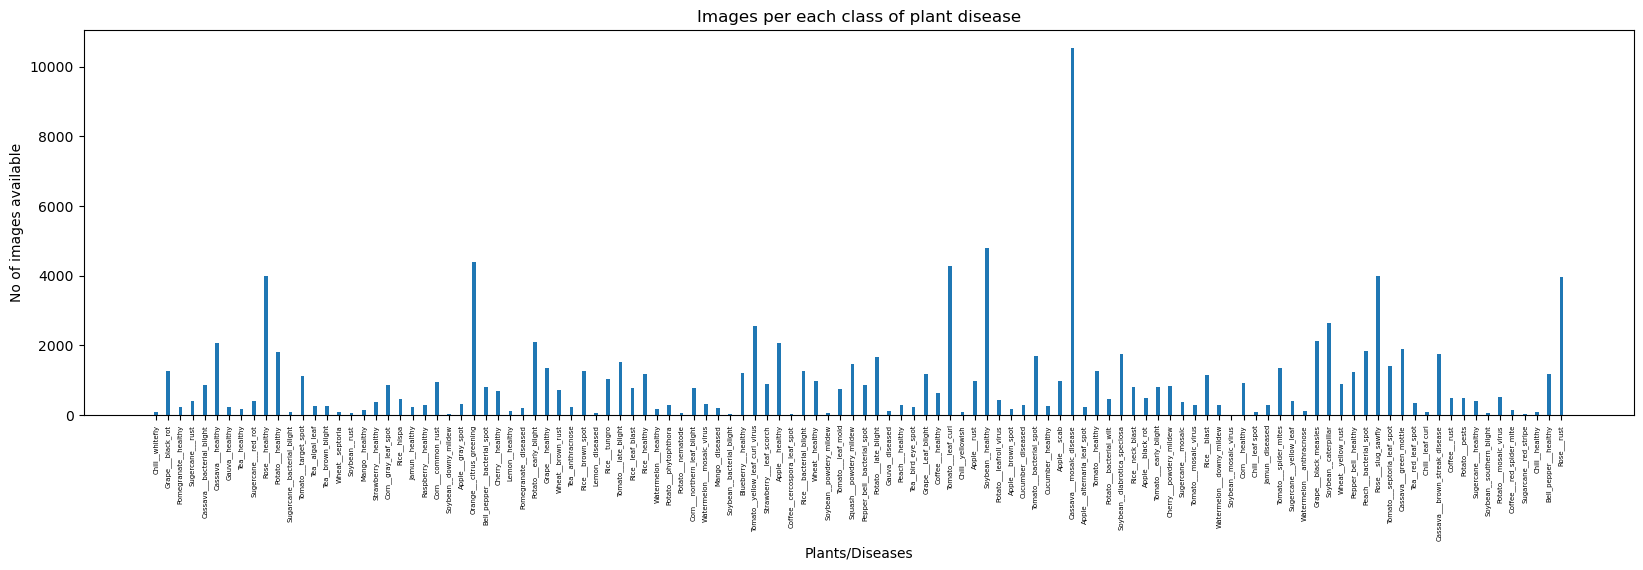

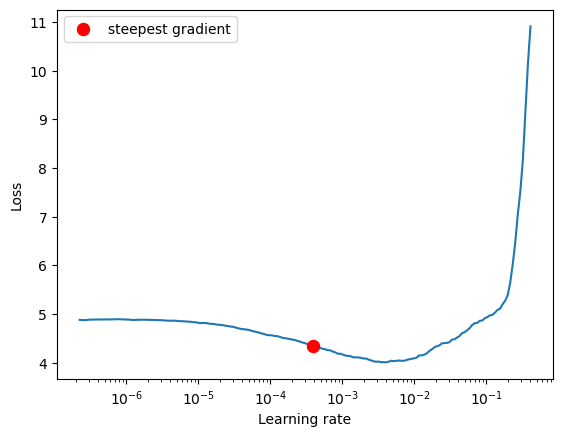


LR Finder suggests a learning rate of: 4.06e-04 for the virtual batch size.


In [22]:
from torch_lr_finder import LRFinder
import numpy as np

print(f"\n--- Finding Optimal LR for a VIRTUAL batch size of {VIRTUAL_BATCH_SIZE} ---")

finder_model = CustomCNN(EnhancedResidualBlock, [2, 2, 2, 2], num_classes=NUM_CLASSES).to(device)
temp_optimizer = optim.AdamW(finder_model.parameters(), lr=1e-7, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

lr_finder = LRFinder(finder_model, temp_optimizer, criterion, device=device)

# ✨ Pass the accumulation_steps to the finder ✨
lr_finder.range_test(
    dataloaders['train'], 
    end_lr=1, 
    num_iter=200, 
    accumulation_steps=accumulation_steps # <-- The key addition
)

# The rest of the logic remains the same
losses = np.array(lr_finder.history["loss"])
lrs = np.array(lr_finder.history["lr"])
min_loss_idx = np.argmin(losses)
suggested_lr = lrs[min_loss_idx] / 10

lr_finder.plot()
lr_finder.reset()

print(f"\nLR Finder suggests a learning rate of: {suggested_lr:.2e} for the virtual batch size.")

In [23]:
LEARNING_RATE = suggested_lr
NUM_EPOCHS = 30 # Train for a reasonable number of epochs

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# OneCycleLR is excellent for training from scratch
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=LEARNING_RATE, 
                                          epochs=NUM_EPOCHS, 
                                          steps_per_epoch=len(dataloaders['train']))

print(f"Training configured with AdamW, OneCycleLR, and an optimal max_lr of {LEARNING_RATE:.2e}")

Training configured with AdamW, OneCycleLR, and an optimal max_lr of 4.06e-04


In [24]:
LOAD_CHECKPOINT = True
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
start_epoch = 0
if LOAD_CHECKPOINT and os.path.exists(CHECKPOINT_PATH):
    print(f"Checkpoint found at {CHECKPOINT_PATH}. Loading...")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from Epoch {start_epoch}")
else:
    print("No checkpoint found. Starting training from scratch.")

No checkpoint found. Starting training from scratch.


In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, start_epoch=0, 
                early_stopping_patience=5, load_optimizer_state=True, accumulation_steps=1): # <-- New parameter
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_epoch = start_epoch
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lrs': []}

    scaler = torch.amp.GradScaler('cuda', enabled=(device.type == 'cuda'))

    # Checkpoint loading logic remains the same...
    if os.path.exists(CHECKPOINT_PATH):
        print(f"Checkpoint found at {CHECKPOINT_PATH}. Loading model weights...")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        best_acc = checkpoint.get('accuracy', 0.0)
        print(f"Loaded best accuracy from previous run: {best_acc:.4f}")
        
        if LOAD_CHECKPOINT and load_optimizer_state:
            print("Loading optimizer and scheduler state to resume training...")
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming training from Epoch {start_epoch}")
        else:
            print("Starting a new training stage. Optimizer and scheduler are NOT loaded from checkpoint.")

    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}'); print('-' * 10)
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            
            # ✨ THE GRADIENT ACCUMULATION LOGIC STARTS HERE ✨
            # We only accumulate during the training phase
            if phase == 'train':
                optimizer.zero_grad() # Zero out gradients at the start of the epoch's training phase

            # Use enumerate to get the batch index 'i'
            for i, (inputs, labels) in enumerate(tqdm(dataloaders[phase], desc=f"{phase} phase")):
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                
                # The forward pass is the same
                with torch.set_grad_enabled(phase == 'train'):
                    with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        # Scale the loss by the number of accumulation steps
                        # This normalizes the gradient, so the accumulated total is correct
                        scaled_loss = loss / accumulation_steps
                        
                        # Backpropagate the scaled loss
                        scaler.scale(scaled_loss).backward()

                        # Only update weights every 'accumulation_steps'
                        if (i + 1) % accumulation_steps == 0:
                            scaler.unscale_(optimizer)
                            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                            scaler.step(optimizer)
                            scaler.update()
                            optimizer.zero_grad() # Zero out for the next accumulation cycle

                            if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                                scheduler.step()
                                history['lrs'].append(optimizer.param_groups[0]['lr'])
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # The rest of the function (epoch stats, validation, saving) remains the same...
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss); history['train_acc'].append(epoch_acc.item())
                writer.add_scalar('Loss/train', epoch_loss, epoch)
                writer.add_scalar('Accuracy/train', epoch_acc, epoch)
            else: # val phase
                history['val_loss'].append(epoch_loss); history['val_acc'].append(epoch_acc.item())
                writer.add_scalar('Loss/val', epoch_loss, epoch)
                writer.add_scalar('Accuracy/val', epoch_acc, epoch)
                writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], epoch)
                
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)
                    history['lrs'].append(optimizer.param_groups[0]['lr'])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc, best_epoch, epochs_no_improve = epoch_acc, epoch, 0
                    best_model_wts = model.state_dict()
                    save_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
                    torch.save({'epoch': epoch, 'model_state_dict': best_model_wts, 'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict(), 'loss': epoch_loss, 'accuracy': best_acc}, save_path)
                    print(f"New best model saved with accuracy: {best_acc:.4f}")
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= early_stopping_patience:
                        print(f"Early stopping triggered. No improvement in {early_stopping_patience} validation epochs.")
                        model.load_state_dict(best_model_wts)
                        writer.close()
                        return model, history
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch+1}')
    last_epoch_path = os.path.join(CHECKPOINT_DIR, 'last_model.pth')
    torch.save({
        'epoch': num_epochs - 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, last_epoch_path)
    print(f"Last checkpoint saved to {last_epoch_path}")

    model.load_state_dict(best_model_wts)
    writer.close()
    return model, history

In [26]:
model, history = train_model(model, criterion, optimizer, scheduler, 
                             num_epochs=NUM_EPOCHS, 
                             start_epoch=start_epoch,
                             early_stopping_patience=5,
                             accumulation_steps=accumulation_steps) 

Epoch 1/30
----------


train phase:  61%|██████▏   | 4364/7113 [12:07<07:38,  6.00it/s]


KeyboardInterrupt: 

In [ ]:


# --- UNIFIED PLOTTING FUNCTION ---
def plot_training_history(history, model_name):
    """
    Plots training & validation accuracy/loss. Annotates best val accuracy.
    """
    train_acc = history['train_acc']
    val_acc = history['val_acc']
    train_loss = history['train_loss']
    val_loss = history['val_loss']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle(f'Training History for {model_name}', fontsize=16)

    ax1.plot(train_acc, label='Train Acc', marker='o')
    ax1.plot(val_acc, label='Val Acc', marker='o')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True, alpha=0.3)

    if val_acc:
        best_epoch = int(np.argmax(val_acc))
        best_val_acc = val_acc[best_epoch]
        ax1.axvline(best_epoch, color='r', linestyle='--', linewidth=1)
        ax1.annotate(f'Best: {best_val_acc:.4f}\nEp {best_epoch+1}',
                     xy=(best_epoch, best_val_acc),
                     xytext=(best_epoch, max(0, best_val_acc - 0.1)),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     ha='center', fontsize=10)
    ax1.legend()

    ax2.plot(train_loss, label='Train Loss', marker='o')
    ax2.plot(val_loss, label='Val Loss', marker='o')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()


def plot_learning_rate_schedule(history):
    lrs = history.get('lrs', [])
    if len(lrs) > 0:
        plt.figure(figsize=(12,4))
        plt.plot(lrs)
        plt.title('Learning Rate (per batch)')
        plt.xlabel('Batch # (cumulative)')
        plt.ylabel('LR')
        plt.grid(alpha=0.3)
        plt.show()
    else:
        print('No LR data to plot.')

# --- Evaluation helpers ---
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Eval'):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds


def plot_confusion_matrix(labels, preds, class_names, normalize=True, max_classes_display=50):
    cm = confusion_matrix(labels, preds)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    # If too many classes, show a subset heatmap legend only
    if len(class_names) > max_classes_display:
        print(f"Too many classes ({len(class_names)}). Showing aggregated stats.")
        avg_diag = np.nanmean(np.diag(cm))
        print(f"Mean per-class accuracy: {avg_diag:.4f}")
        return
    plt.figure(figsize=(min(1+0.3*len(class_names), 25), min(1+0.3*len(class_names), 25)))
    sns.heatmap(cm, cmap='viridis', xticklabels=class_names, yticklabels=class_names, fmt='.2f' if normalize else 'd')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.tight_layout()
    plt.show()


def show_misclassified(model, dataloader, class_names, device, n=12):
    model.eval()
    images = []
    labels_true = []
    labels_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            mismatch = preds != labels.to(device)
            if mismatch.any():
                for i in torch.where(mismatch)[0]:
                    images.append(inputs[i].cpu())
                    labels_true.append(labels[i].item())
                    labels_pred.append(preds[i].item())
                    if len(images) >= n:
                        break
            if len(images) >= n:
                break
    if len(images) == 0:
        print('No misclassifications found in this subset.')
        return
    # Denormalize for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    cols = 4
    rows = int(np.ceil(len(images)/cols))
    plt.figure(figsize=(cols*4, rows*4))
    for idx, img in enumerate(images):
        img_dn = img*std + mean
        img_np = np.clip(img_dn.permute(1,2,0).numpy(), 0, 1)
        ax = plt.subplot(rows, cols, idx+1)
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title(f"T: {class_names[labels_true[idx]][:15]}\nP: {class_names[labels_pred[idx]][:15]}", fontsize=9)
    plt.suptitle('Sample Misclassified Images', fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Grad-CAM (lightweight) ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1)
        selected = output[0, class_idx]
        selected.backward(retain_graph=True)
        weights = self.gradients.mean(dim=[2,3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = torch.nn.functional.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam_min, cam_max = cam.min(), cam.max()
        cam = (cam - cam_min)/(cam_max - cam_min + 1e-8)
        return cam[0,0].cpu().numpy()


def visualize_gradcam(model, dataloader, class_names, device, n=3):
    # Pick the last residual layer for Grad-CAM
    target_layer = model.layer4[-1].bn2
    gradcam = GradCAM(model, target_layer)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    shown = 0
    for inputs, labels in dataloader:
        for i in range(inputs.size(0)):
            if shown >= n:
                return
            inp = inputs[i:i+1].to(device)
            cam = gradcam.generate(inp)
            img = (inputs[i]*std + mean).permute(1,2,0).numpy()
            img = np.clip(img, 0, 1)
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.imshow(cam, cmap='jet', alpha=0.4)
            pred_class = class_names[model(inp).argmax(1).item()]
            plt.title(f"True: {class_names[labels[i]]}\nPred: {pred_class}")
            plt.axis('off')
            plt.show()
            shown += 1

print("Visualization & evaluation helpers ready.")

In [ ]:
print("\n--- Generating Training Plots ---")
plot_training_history(history, MODEL_NAME)
plot_learning_rate_schedule(history)

In [ ]:
print("\n--- Evaluating on Test Set ---")
# IMPORTANT: Load the BEST model from checkpoint for final evaluation
print("Loading best model for final evaluation...")
final_model = CustomCNN(EnhancedResidualBlock, [2, 2, 2, 2], num_classes=NUM_CLASSES)
if int(torch.__version__.split('.')[0]) >= 2:
    # Check the operating system
    if platform.system() != "Windows":
        try:
            final_model = torch.compile(final_model) # Compile the evaluation model too
        except Exception as e:
            print(f"Could not compile the final model: {e}")
final_model.to(device)
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
final_model.load_state_dict(checkpoint['model_state_dict'])

# Get predictions and labels
test_labels, test_preds = evaluate_model(final_model, dataloaders['test'], class_names, device)

# Print Classification Report
print("\n--- Classification Report ---")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

# Plot Confusion Matrix
print("\n--- Confusion Matrix ---")
plot_confusion_matrix(test_labels, test_preds, class_names)

# Show some misclassified images
print("\n--- Sample Misclassified Images ---")
show_misclassified(final_model, dataloaders['test'], class_names, device)

# Show Grad-CAM visualizations
print("\n--- Grad-CAM Visualizations ---")
# For Grad-CAM, it's often better to target the final conv layer before the BN
target_layer = final_model.layer4[-1].conv2 
visualize_gradcam(final_model, dataloaders['test'], class_names, device, target_layer=target_layer)